In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import itertools
import random as random

colors_ls = (list(mcolors.TABLEAU_COLORS)[:120])
colors_ls_cyc = itertools.cycle(list(mcolors.TABLEAU_COLORS)[:120])
markers_ls = ['o','s','v', ',', '+', '.', 'o', '*']
markers = itertools.cycle(markers_ls)

from scipy.special import psi
from scipy.special import polygamma
from scipy.special import erf, erfinv
from scipy.optimize import curve_fit

mpl.style.use('classic')
mpl.style.use(['seaborn-whitegrid'])
from matplotlib.ticker import ScalarFormatter, NullFormatter
mpl.rcParams['figure.dpi'] = 400
mpl.rcParams.update({'font.size': 16})

current_dir = os.getcwd() 
kPSep = os.sep

# General pure states

We consider the system with $V$ modes dividing it on $V_A$ and $V_B$ subsystems such that $\mathcal{H}=\mathcal{H_A}\otimes\mathcal{H_B}$.
- $ f = V_A/V$
- $ d_A = 2 ^ {V_A}$
- $ d_B = 2 ^{V-V_A}$

We will the fraction number $f$ and with having the number of dimensions $D$ and fermionic nodes per site $N_{int}$

- $V=L^{D}N_{int}$
- $S_A(|\psi \rangle) = - \text{Tr}_{\mathcal{H_A}}\left[\hat{\rho}_A \ln \hat{\rho}_A \right] \quad \hat{\rho}_A = \text{Tr}_B |\psi\rangle\langle\psi|$ 



## Arbitrary number of particles

The average entanglement entropy of a uniformly distributed pure state in $\mathcal{H}$ restricted to subsystem A is given by the Page formula:
$$
    \langle S_A \rangle = 
    \left\{
    \begin{array}{lc}
        \Psi(d_Ad_B+1) - \Psi(d_B + 1) - \frac{d_A - 1}{2d_B}, & d_A\leq d_B \\
        \Psi(d_Ad_B+1) - \Psi(d_A + 1) - \frac{d_B - 1}{2d_A}, & \text{otherwise}
    \end{array}
    \right.,
$$

where $\Psi(x) = \Gamma ' (x) / \Gamma (x)$ is a digamma function.

Going to a thermodynamic limit, in big systems we can fix a fraction $f = V_A/V$ so what we get is:
$$
    \langle S_A \rangle = f V\ln 2 - 2 ^{-|1-2f|V-1} + O(2^{-V}),
$$
where we see the volueme law. For $f \neq \frac{1}{2}$, the second term is an exponentially small correction and becomes $-\delta _{f,1/2}$ as $V\rightarrow \infty$.

The variance is given for $d_A \leq d_B$:
$$
(\Delta S_A )^2 = \frac{d_A + d_B}{d_Ad_B + 1}\Psi ' (d_B + 1) - \Psi ' (d_Ad_B + 1) - \frac{(d_A - 1)(d_A + 2d_B - 1)}{4d_B^2(d_Ad_B + 1)},
$$
which again in the termodynamic limit becomes:
$$
(\Delta S_A )^2 = \left(\frac{1}{2}-\frac{1}{4}\delta_{f,1/2}\right)2^{-(1+|1-2f|)V}+o\left(2^{-(1+|1-2f|)V}\right).

# Function definitions

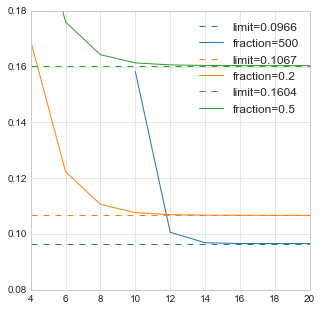

In [3]:
def page_result(d_a, d_b):
    if d_a <= d_b:
        return psi(d_a * d_b + 1) - psi(d_b + 1) - (d_a - 1)/(2*d_b)
    else:
        return psi(d_a * d_b + 1) - psi(d_a + 1) - (d_b - 1)/(2*d_a)

def page_result_var(d_a, d_b):
    return (((d_a + d_b)/(d_a*d_b + 1.0)) * polygamma(1, d_b + 1)) - polygamma(1, d_a*d_b + 1) - ((d_a-1)*(d_a + 2.0 * d_b - 1.0))/(4.0 * d_b * d_b * (d_a * d_b  + 1.0))

def page_thermodynamic(f, L, c = 1):
    return f * L * np.log(2.) - np.power(2., -np.abs(1-2*f)*L - 1) #+ 100 * np.power(2., -L)

def fit_page(l, a):
    return -a * np.power(2., -l)

def page_thermodynamic_var(f, L, c = 100):
    return (1/2 - 1/4 * (1.0 if f == 1/2 else 0.0)) * np.power(2., -(1+np.abs(1-2*f))*L) #+ 100*np.power(2., -(1.0+np.abs(1-2*f))*L)

def their_result(fraction_h, V):
    frac = fraction_h if fraction_h <= 1 else fraction_h/np.power(2.0, V)
    val = (V-1.0)*np.log(2)/2.0
    val += 2.0 * (np.exp(-np.power(erfinv(frac), 2.0)) - 1.0) / (frac * np.pi)
    return  val + (-2.0 + 2.0 * frac + np.exp(-np.power(erfinv(frac), 2.0)))*erfinv(frac)/(2.0*frac*np.sqrt(np.pi)) 

def page_their(la, L, c = 1.0):
    da = np.power(2.0, la)
    db = np.power(2.0, L-la)
    
    return np.log(da) - da / (2.0 * db) + c * 1.0/(da*db)

def plot_diff_page_their(L, frac, c = 1.0):
    fig, ax = plt.subplots(figsize=(5,5))
    for fr in frac:
        values = []
        for l in L:
            val = page_their(l//2, l) - their_result(fr, l)
            values.append(val)
        l = 1000
        color = next(colors_ls_cyc)
        limit = page_their(l//2, l, c) - their_result(fr, l)
        ax.axhline(y=limit, color=color, linestyle='--', label = f"limit={limit:.4f}")
        ax.plot(L, values, label=f'fraction={fr}', color=color)
    ax.legend()
    ax.set_ylim([0.08, 0.18])
    #ax.set_yscale('log')
    
c = 1e-5
plot_diff_page_their([i for i in range(4,22, 2)], [500, 0.2,0.5], c)

# Define the model

In [27]:
from math import ceil
from re import A


class ising_transverse:
    def __init__(self, Ns, J, J0, g, g0, h, w, sym = False, k = 0, p = 1, x = 1, bc = 0, const_fraction = True):
        # if constant fraction means that we need to take care of how many do we take from given sector
        self.const_fraction = const_fraction
        
        self.N = 1
        self.Ns = 1
        self.N_full = 1
        self.all_symmetries = []
        self.real_symmetries = []
        self.bc = bc
        self.set_Ns(Ns)
        
        self.J = J
        self.J0 = J0
        self.g = g
        self.g0 = g0
        self.h = h
        self.w = w

        self.k = k
        self.p = p
        self.x = x
        self.sym = sym
        
    def set_Ns(self, Ns):
        self.Ns = Ns
        self.N = 1
        self.N_full = np.power(2, self.Ns)
        if self.bc == 0:
            self.all_symmetries = [(i, 1) for i in range(0, self.Ns)] + [(0, -1)] + ([(Ns//2, -1)] if self.Ns % 2 == 0 else [])
            self.real_symmetries = [str((0, 1)), str((0, -1))] + ([str((Ns//2, -1)), str((Ns//2, 1))] if self.Ns % 2 == 0 else [])
        else:
            self.all_symmetries = [(0, 1), (0, -1)]
            self.real_symmetries = [(0, 1), (0, -1)]
              
    def set_hilbert_space(self, energies):
        self.N = len(energies)
               
    def get_info(self):
        if not self.sym:
            return f"Ns={self.Ns},J={self.J:.2f},J0={self.J0:.2f},g={self.g:.2f},g0={self.g0:.2f},h={self.h:.2f},w={self.w:.2f},bc={self.bc}"
        else:
            return f"Ns={self.Ns},J={self.J:.2f},g={self.g:.2f},h={self.h:.2f},k={self.k:.2f},p={self.p},x={self.x},bc={self.bc}"
        
    def get_info_wo_sym(self):
        if not self.sym:
            return self.get_info()
        else:
            return f"Ns={self.Ns},J={self.J:.2f},g={self.g:.2f},h={self.h:.2f},bc={self.bc}"
    
    def get_dir(self, dir = "resultsSym"):
        directory = dir + str(self.Ns) + kPSep
        if self.sym:
            return directory + f"_ising_sym," + self.get_info() + kPSep
        else:
            return directory + f"_ising," + self.get_info() + kPSep
    
    def check_files(self, fraction, dir, name, columns):
        directory = self.get_dir(dir)
        
        tmp = None
        frac = fraction
        if not os.path.exists(directory):
            return pd.DataFrame(), frac
        
        files = os.listdir(directory)
        if frac > 1.0:
            tmp = name + f"{int(frac)}.dat"
            if tmp not in files or frac > self.N:
                tmp = None
        else:
            tmp = None
            for file in files:
                if f"{frac:.2f}x" in file and file.startswith(name):
                    tmp = file
                    break        
                
        if tmp is not None:
            if columns is not None:
                df = pd.read_csv(directory + tmp, names = columns, sep="\t")
                return df, frac
            else:
                df = pd.read_csv(directory + tmp, sep="\t", header=None,)
                if len(df) == self.Ns//2:
                    return df, frac
        return pd.DataFrame(), frac
    
    def get_values_num(self, fraction):
        if self.const_fraction:
            # if we take constant number of states we weight by the Hilbert size
            if fraction <= 1.0:
                return int(fraction * self.N)
            else:
                return round(fraction * self.N / self.N_full)
        else:
            return int(fraction * self.N) if fraction <= 1.0 else int(fraction)

    # ------------------------------- creating file with averages --------------------------------
    '''
    Creates files with given averages assuming that there exists one file from to_check
    '''
    def create_averages_files(self, fractions, dir = "{kPSep}resultsSym"):
        self.get_energy_file(dir)
        to_check = [0.5, 0.2, 500]
        # check for half of the spectrum first
        df, frac = self.get_entropies_file(0.5, dir)
        columns = df.columns
        
        # iterate through fractions
        for fraction in fractions:
            cols_to_take = columns[1:-1]
            states_num = len(cols_to_take)
            name = "spectrum_num=" + (f"{fraction:.2f}x{self.N}={len(cols_to_take)}" if fraction <= 1.0 else f"{int(fraction)}")
            name_av = self.get_dir(dir) + 'av_entropies,' + name + '.dat'
            name_var = self.get_dir(dir) + 'var_entropies,' + name + '.dat'
            if os.path.exists(name_av) and os.path.exists(name_var):
                break

            if int(fraction * self.N) < frac or (fraction > 1 and fraction < frac):                
                values_num = self.get_values_num(fraction)
                if values_num >= self.N:
                    print(f"Too much for k={self.k},p={self.p},x={self.x},Ns={self.Ns} model")
                    continue
                
                # how much there is
                av_idx = int(states_num / 2)
                # bounds
                lower = av_idx - values_num // 2 - 1
                upper = av_idx + values_num // 2
                cols_to_take = cols_to_take[lower : upper]
                cols_to_take = [columns[0]] + list(cols_to_take)
                
                df_tmp = df.loc[:,[columns[0]] + list(cols_to_take)]
                df_tmp['av_S'] = df_tmp[cols_to_take].mean(axis=1)
                df_tmp['var_S'] = df_tmp[cols_to_take].var(axis=1)
                
                index = [i for i in range(1, self.Ns//2 + 1)]
                df_tmp.index = index

                
                #print(f'for {self.get_info()} created v={fraction}')
                
                df_tmp[['var_S', 'av_S']].to_csv(name_var, sep = '\t', header=False)
                if fraction in to_check:
                    continue
                df_tmp[['av_S', 'var_S']].to_csv(name_av, sep = '\t', header=False)
    
    '''
    Creates files with given averages assuming that there exists one file from to_check - all symmetry sectors
    '''           
    def create_averages_all_sectors(self, fractions, dir = "{kPSep}resultsSym"):
        k_start = self.k
        p_start = self.p
        
        for i in self.all_symmetries:
            self.k = i[0]
            self.p = i[1]
            self.create_averages_files(fractions, dir)
        
        self.k = k_start
        self.p = p_start

    def create_entropies(self, fractions, dir):
        self.get_energy_file(dir)
        to_check = [0.5, 0.2, 500]
        # check for half of the spectrum first
        df, frac = self.get_entropies_file(0.5, dir)
        columns = df.columns
        # iterate through fractions
        for fraction in fractions:
            cols_to_take = columns[1:-1]
            states_num = len(cols_to_take)
            name = "spectrum_num=" + (f"{fraction:.2f}x{self.N}={len(cols_to_take)}" if fraction <= 1.0 else f"{int(fraction)}")
            name = self.get_dir(dir) + 'entropies,' + name + '.dat'
            if os.path.exists(name):
                break

            if int(fraction * self.N) < frac or (fraction > 1 and fraction < frac):                
                values_num = self.get_values_num(fraction)
                if values_num >= self.N:
                    print(f"Too much for k={self.k},p={self.p},x={self.x},Ns={self.Ns} model")
                
                # how much there is
                av_idx = int(states_num / 2)
                # bounds
                lower = av_idx - values_num // 2 - 1
                upper = av_idx + values_num // 2
                cols_to_take = cols_to_take[lower : upper]
                cols_to_take = [columns[0]] + list(cols_to_take)
                
                df_tmp = df.loc[:,[columns[0]] + list(cols_to_take)]
                
                index = [i for i in range(1, self.Ns//2 + 1)]
                df_tmp.index = index
                
                #print(f'for {self.get_info()} created v={fraction}')
                
                if fraction in to_check:
                    continue
                df_tmp['empty'] = df_tmp.iloc[:,0]
                df_tmp[cols_to_take[1:] + ['empty']].to_csv(name, sep = '\t', header=False)

    def create_entropies_all_sectors(self, fractions, dir):
        k_start = self.k
        p_start = self.p
        
        for i in self.all_symmetries:
            self.k = i[0]
            self.p = i[1]
            self.create_entropies(fractions, dir)
        
        self.k = k_start
        self.p = p_start        

    # ------------------------------- getting file with averages --------------------------------
    ''' 
    Gets the file with averages over different subsystem sizes
    '''         
    def get_averages_file(self, fraction, dir = "{kPSep}resultsSym"):
        self.get_energy_file(dir)
        df, frac = self.check_files(
            fraction, 
            dir,
            "av_entropies,spectrum_num=",
            columns = ["L_a", "av_S", "empty"]
            )
        if len(df) == 0:
            return pd.DataFrame(), 1
        
        df['L_a'] = df['L_a'] / self.Ns
        return df.drop(["empty"], axis=1), frac
    
    '''
    Gets the energy file
    '''
    def get_energy_file(self, dir = "{kPSep}resultsSym"):
        df = None
        
        directory = self.get_dir(dir)
        if not os.path.exists(directory):
            return pd.DataFrame(), 1
        
        files = os.listdir(directory)
        for file in files:
            if file.startswith('energies,'):
                df = pd.read_csv(directory + file, names = ["energy"], sep="\t")
                if len(df) != 0:
                    break            
            
        if len(df) == 0:
            self.N = 0
            return pd.DataFrame(), 1
        
        self.set_hilbert_space(df)
        return df, self.N
    
    # ------------------------------- getting all entropies together --------------------------------
    '''
    Gets the file with different entropies
    '''
    def get_entropies_file(self, fraction, dir = "{kPSep}resultsSym"):
        
        df, frac = pd.DataFrame(), 1    
        to_check = [fraction, 0.5, 0.2]
        i = 0
        while len(df) == 0 and i < len(to_check):
            self.get_energy_file(dir)
            # extract other fractions from the bigger ones
            df, frac = self.check_files(
                to_check[i], 
                dir,
                "entropies,spectrum_num=",
                columns = None
                )
            i+=1
        
        values_num = self.get_values_num(fraction)
        if len(df) == 0 or values_num >= self.N:
            print(f"Too much for k={self.k},p={self.p},x={self.x},Ns={self.Ns} model")           
            self.N = 0
            return pd.DataFrame(), 1.0
        
        df.rename(columns={0: "L_a"}, inplace = True)
        df['L_a'] = df['L_a'] / self.Ns
        columns = df.columns

        if frac == fraction or frac == int(fraction):
            # if it is already the file that we wanted
            return df.drop(columns[-1], axis = 1), len(df.columns[1:-1])
        else:
            cols_to_take = columns[1:-1]
            # how much there is
            states_num = len(cols_to_take)
            av_idx = int(states_num / 2)
            # bounds
            lower = av_idx - values_num // 2 - 1
            upper = av_idx + values_num // 2
            cols_to_take = cols_to_take[lower : upper]
            cols_to_take = [columns[0]] + list(cols_to_take)
                   
            return df[cols_to_take], values_num
    
    '''
    Concatenates all entropies from different sectors that we want together
    '''
    def concat_entropies(self, fraction, dir = "{kPSep}resultsSym", all = True, real = False):
        df = pd.DataFrame(columns = ['sector'] + [i/self.Ns for i in range(1, self.Ns//2 + 1)])
        syms = (self.all_symmetries if not real else self.real_symmetries) if all else [(self.k,self.p)]
        
        N = 0
        for i in syms:
            self.k = i[0]
            self.p = i[1]
            df_tmp, frac = self.get_entropies_file(fraction, dir)
            # append to check
            #N += int(frac * self.N) if frac <= 1.0 else frac
            df_tmp2 = pd.DataFrame()
            for index, row in df_tmp.iterrows():
                L_a = row['L_a']
                values = row[df_tmp.columns[1:]]
                df_tmp2[L_a] = np.array(values)
                
            df_tmp2['sector'] = [(self.k,self.p) for i in range(len(df_tmp2))]
            # append to the dataframe
            df = df.append(df_tmp2, ignore_index = True)
        print(self.get_info() + "\n\t->" + f"N={len(df)}")
        return df
    
    
    # ------------------------------- getting variance of entropies together --------------------------------

    '''
    Returns the dataframe with the variance
    '''     
    def get_variance(self, fraction, dir = "{kPSep}resultsSym"):
        self.get_energy_file(dir)
        # check if such file is saved already
        df, frac = self.check_files(
            fraction, 
            dir,
            "var_entropies,spectrum_num=",
            columns = ["L_a", "var", "empty"]
            )
        if len(df) == 0:
            df, frac = self.get_entropies_file(fraction, dir)
        else:
            df['L_a'] = df['L_a'] / self.Ns
            return df.drop(["empty"], axis=1), frac          
          
        # if it fails again    
        if len(df) == 0:
            return pd.DataFrame(), 1
        
        col = (df[df.columns[1:]].var(axis = 1))
        df['var'] = col
        return df[['L_a', 'var']], frac
    
    
    # ------------------------------- getting different symmetry sectors entropies together --------------------------------

    '''
    Returns the dataframe with averages in each symmetry sectors
    '''
    def symmetry_sectors(self, fraction, dir = "{kPSep}resultsSym", var = False, real = False):
        df = pd.DataFrame()
        df['L_a'] = np.array([i for i in range(1, self.Ns//2 + 1)]) / self.Ns
        
        col_name = 'av_S' if not var else 'var'
        #self.create_averages_all_sectors([fraction], dir)
        N_all = 0
        for i in self.all_symmetries:
            self.k = i[0]
            self.p = i[1]
            if not (str(i) in self.real_symmetries) and real:
                continue
            df_tmp, frac = self.get_averages_file(fraction, dir) if not var else self.get_variance(fraction, dir)
            if len(df_tmp) != 0:
                val_num = self.get_values_num(fraction)
                df[str(i) + f':{val_num}'] = np.array(df_tmp[col_name])
            else:
                print(f"\t->For {self.Ns} missing {'variance ' if var else ''}{i},frac={fraction},bc={self.bc}")
            N_all += self.N
        if (self.bc==0 and not real) or (self.bc == 1):
            print(f"{('Did' if (self.N_full==N_all) else 'Didnt')} capture whole Hilbert space - for Ns = {self.Ns}, bc = {self.bc}")
        return df
    
    '''
    Gets all different symmetry sectors mean from all entropies file
    '''
    def get_all_symmetry_sectors(self, fraction, dir = "{kPSep}resultsSym"):
        df, frac = pd.DataFrame(), 1
        df['L_a'] = np.array([i for i in range(1, self.Ns//2 + 1)]) / self.Ns
        
        col_name = 'av_S'
        N_all = 0
        N_val = 0
        for i in self.all_symmetries:
            self.k = i[0]
            self.p = i[1]
            
            df_tmp, values_num = self.get_entropies_file(fraction, dir)
            #print(df_tmp)
            if len(df_tmp) != 0:
                df_tmp[col_name] = df_tmp[df_tmp.columns[1:]].mean(axis=1)
                df[str(i) + f':{values_num}'] = np.array(df_tmp[col_name])
            else:
                print(f"\t->For {self.Ns} missing {i},frac={fraction},bc={self.bc}")
            N_val += values_num
            N_all += self.N
        if fraction <= 1.0:
            print(f"{('Did' if (self.N_full==N_all) else 'Didnt')} capture whole Hilbert space - for Ns = {self.Ns}, bc = {self.bc}, N_val={N_val}")
        else:
            print(f"{('Did' if (fraction==N_val) else 'Didnt')} capture all - for Ns = {self.Ns}, bc = {self.bc}, N_val={N_val}") 
        return df
    
    '''
    Averages over specific symmetry sectors
    '''
    def average_symmetry_sectors(self, fraction, dir = "{kPSep}resultsSym", real = False, var = False):
        #self.create_averages_all_sectors([fraction], dir)
        df = self.symmetry_sectors(fraction, dir, var, real)
        
        col_name = 'av_S' if not var else 'var'
        df[col_name] = [0.0 for i in range(len(df))]
    
        columns = df.columns
        columns = columns[1:-1]
        
        norm = 0
        for col in columns:
            N_tmp = int(col.split(':')[-1])
            sym = col.split(':')[0]
            if real and (sym not in self.real_symmetries):
                continue
            df.loc[:,col_name] += (N_tmp * df.loc[:,col]) if not self.const_fraction else df.loc[:,col]
            norm += N_tmp if not self.const_fraction else 1
            
        df[col_name] /= norm
        return df[['L_a', col_name]], 1
    
    '''
    Averages over specific symmetry sectors in one dataframe
    '''
    def average_symmetry_sectors_df(self, df : pd.DataFrame):
        
        av_real = 'av_Sr'
        N_r = 0
        av_other = 'av_So'
        N_o = 0
        av_together = 'av_S'
        N_t = 0
        df_tmp = pd.DataFrame(columns=[av_real, av_other, av_together])
        df_tmp.loc[0] = [0.,0.,0.]
        for col in df.columns:
            N_tmp = int(col.split(':')[-1]) if not self.const_fraction else 1
            sym = col.split(':')[0]
            if sym in self.real_symmetries:
                N_r += N_tmp
                df_tmp.loc[:,av_real] += N_tmp * np.array(df.loc[:,col])
            else:
                N_o += N_tmp
                df_tmp.loc[:,av_other] += N_tmp * np.array(df.loc[:,col])
                
            N_t += N_tmp
            df_tmp.loc[:,av_together] += N_tmp * np.array(df.loc[:,col])
            
        df_tmp[av_real] /= N_r
        df_tmp[av_other] /= N_o
        df_tmp[av_together] /= N_t
        
        return df_tmp

# Plotters

## Single Page's result

array([<AxesSubplot:title={'center':'Page result with digamma function for L=16'}, xlabel='f', ylabel='$<S_A>$'>,
       <AxesSubplot:title={'center':'Page result variance for L=16'}, xlabel='f', ylabel='$(\\Delta S_A )^2 _{page}$'>],
      dtype=object)

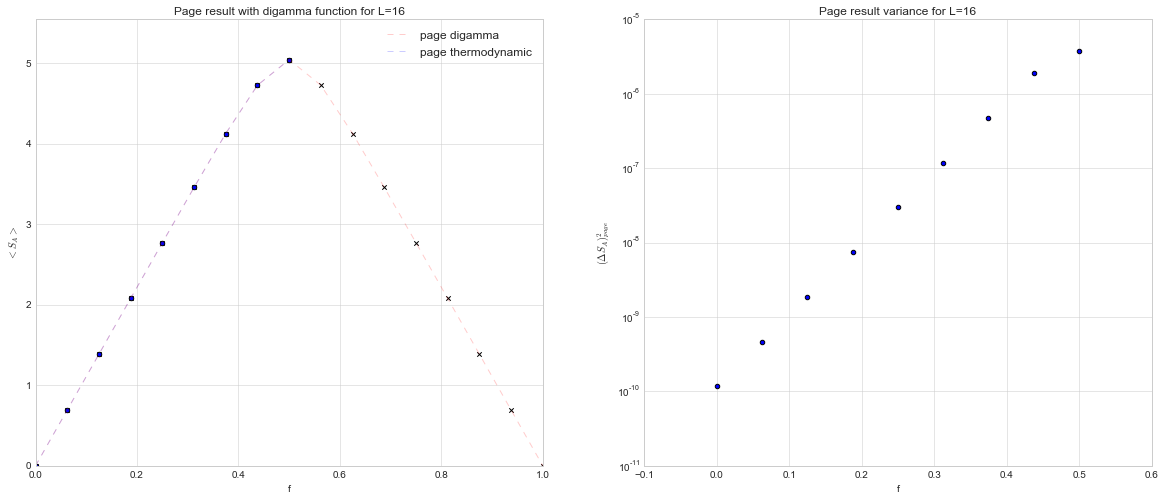

In [5]:
def plot_page(L, legend = True):
    N = np.power(2, L)
    fig, ax = plt.subplots(1,2, figsize = (20,8))
    ax[0].set_xlabel("f")
    ax[1].set_xlabel("f")
    ax[0].set_ylabel("$<S_A>$")
    ax[1].set_ylabel("$(\Delta S_A )^2 _{page}$")
    constant = 1
    constant2 = 10000/L
    
    points = []
    pages = []
    pages_thermo = []
    for L_a in np.arange(0, L+1):
        d_a = np.power(2, L_a)
        d_b = np.power(2, L-L_a)
        f=L_a/L
        page = page_result(d_a, d_b)
        page_var = page_result_var(d_a, d_b)
        page_therm = page_thermodynamic(f, L, constant)
        page_therm_var = page_thermodynamic_var(f, L, constant2)
        
        ax[0].scatter(f, page, c='black', marker ='x')
        if(L_a <= L//2):
            ax[0].scatter(f, page_therm, c='blue', marker ='o')
            #ax[1].scatter(f, page_var, c='black', marker ='x')
            ax[1].scatter(f, page_therm_var, c='blue',marker ='o')
        
        points.append(f)
        pages.append(page)
        
        pages_thermo.append(page_therm)
        
    ax[0].plot(points, pages, color='red', ls = '--', alpha = 0.2, label = "page digamma")
    ax[0].plot(points[0:-L//2], pages_thermo[0:-L//2], color='blue', ls = '--', alpha = 0.2, label = "page thermodynamic")
    if legend:
        ax[0].legend()
    ax[0].set_title(f"Page result with digamma function for L={L}")
    ax[1].set_title(f"Page result variance for L={L}")
    
    ax[1].set_yscale('log')
    ax[0].set_xlim([0, 1])
    ax[0].set_ylim([0, 1/2 * L * np.log(2) + constant * np.power(2., -L)])
    return ax
plot_page(16)

## Many Page's results

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(array([[<AxesSubplot:title={'center':'Average entropy over different lattice sizes'}, xlabel='f', ylabel='$<S_A>$'>,
         <AxesSubplot:title={'center':'Average entropy density over different lattice sizes'}, xlabel='f', ylabel='$<S_A>/V$'>],
        [<AxesSubplot:title={'center':'Average entropy variance over different lattice sizes'}, xlabel='f', ylabel='$(\\Delta S_A )^2$'>,
         <AxesSubplot:title={'center':'Entropy samples for different system sizes'}, xlabel='$f$', ylabel='$<S_A>$'>]],
       dtype=object),
 {10: 'o', 14: 's', 18: 'v', 20: ','},
 {10: 'tab:red', 14: 'tab:purple', 18: 'tab:brown', 20: 'tab:pink'})

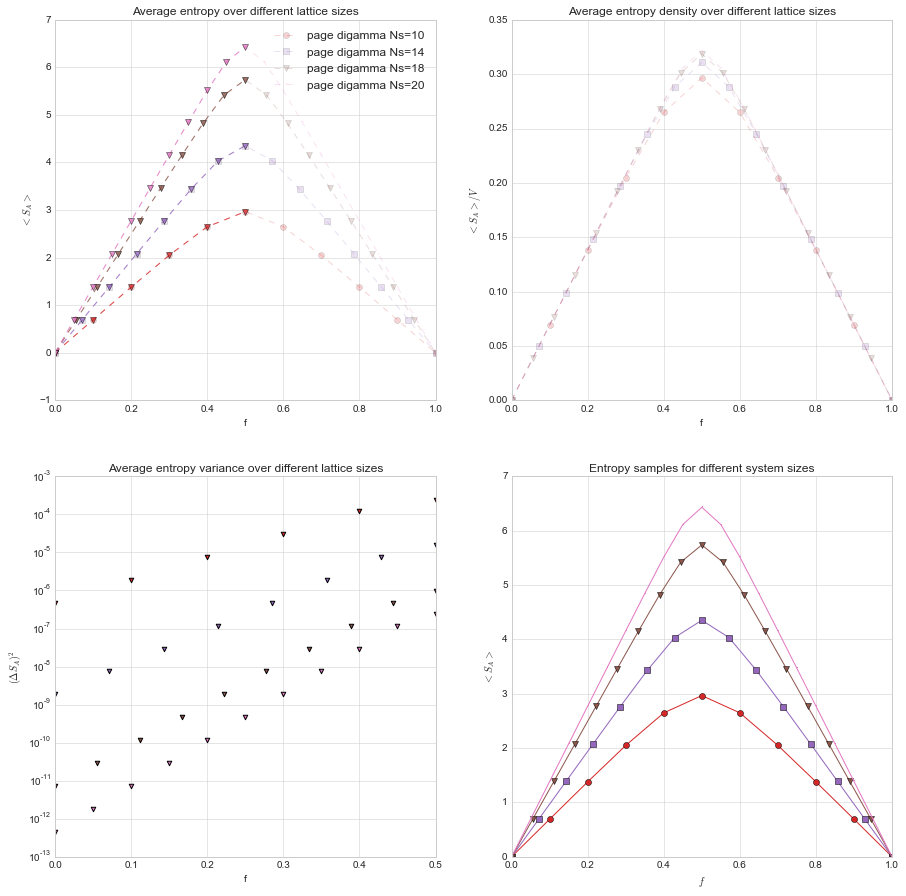

In [6]:
def plot_pages(L, legend = True):
    fig, ax = plt.subplots(2,2, figsize = (15,15))
    
    ax[0][0].set_xlim([0, 1])
    ax[0][0].set_xlabel("f")
    ax[0][0].set_ylabel("$<S_A>$")
    ax[0][0].set_title(f"Average entropy over different lattice sizes")
    
    ax[0][1].set_xlim([0, 1])
    ax[0][1].set_xlabel("f")
    ax[0][1].set_ylabel("$<S_A>/V$")
    ax[0][1].set_title(f"Average entropy density over different lattice sizes")
    ax[0][1].set_ylim([0, np.log(2) * 1/2])
    ax[0][1].set_yticks([0.05 * i for i in range(0, 8)])
    
    ax[1][0].set_xlim([0, 0.5])
    ax[1][0].set_yscale('log')
    ax[1][0].set_xlabel("f")
    ax[1][0].set_ylabel("$(\Delta S_A )^2$")
    ax[1][0].set_title(f"Average entropy variance over different lattice sizes")
    
    ax[1][1].set_xlim([0, 1])
    ax[1][1].set_xlabel("$f$")
    ax[1][1].set_ylabel("$<S_A>$")
    ax[1][1].set_title("Entropy samples for different system sizes")
    
    col = {}
    mark = {}
    
    for l in L:  
        N = np.power(2, l)
    
        points = []
        pages = []
        pages_thermo = []
        
        color_page = next(colors_ls_cyc)
        marker_page = next(markers)
        color_page_therm = color_page
        marker_page_therm = 'v'
        for L_a in np.arange(0, l+1):
            d_a = np.power(2, L_a)
            d_b = np.power(2, l-L_a)
            f=L_a/l
            
            mark[l] = marker_page
            col[l] = color_page
            
            page = page_result(d_a, d_b)
            page_var = page_result_var(d_a, d_b)
            page_therm = page_thermodynamic(f, l, 1)
            page_therm_var = page_thermodynamic_var(f, l, 1)
            
            if(L_a <= l//2):
                #ax[1][0].scatter(f, page_var, c=color_page, marker = marker_page)
                ax[1][0].scatter(f, page_therm_var, c=color_page_therm, marker = marker_page_therm)
            
            points.append(f)
            pages.append(page)
            pages_thermo.append(page_therm)
        
        ax[0][0].plot(points, pages, color=color_page, marker = marker_page, ls = '--',
                   alpha = 0.2, label = f"page digamma Ns={l}")
        
        ax[0][0].plot(points[0:-l//2], pages_thermo[0:-l//2], color=color_page_therm,
                   marker = marker_page_therm, ls = '--',
                   alpha = 0.8)
                
        ax[0][1].plot(points, np.array(pages)/l, color=color_page, marker = marker_page, ls = '--',
                    alpha = 0.2)
       
        ax[1][1].plot(points, pages, color=color_page, marker = marker_page, ls = '-',
                   alpha = 1.0)


    if legend:
        ax[0][0].legend()
        ax[0][1].legend()
        ax[1][0].legend()
        ax[1][1].legend()
        
    return ax, mark, col
plot_pages([10,14,18,20])

## Averages plot

In [7]:
def plot_model_av(model, frac, directory = f"{kPSep}resultsSym"):
    df, fraction = model.get_averages_file(frac, directory)
    df_var, fraction = model.get_variance(frac, directory)
    ax = plot_page(model.Ns, False)
    ax[0].plot(df['L_a'], df['av_S'], label = model.get_info())
    ax[1].plot(df_var['L_a'], df_var['var'], label = model.get_info(), marker = 'x')
    ax[0].legend()
    ax[1].legend()
    return df, fraction
    
def plot_many_scatters(df, ax, color, marker, l, label):
    minima = []
    averages = []
    seventy_fives = []
    quoters = []
    pages = []
    for col in df.columns[1:]:
        x = [float(col) for i in range(len(df))]
        ax.scatter(x, np.array(df[col]), color = color, marker = marker, s = 2, alpha = 0.1)
        minima.append(np.min(np.array(df[col])))
        averages.append(np.average(np.array(df[col])))
        seventy_fives.append(np.quantile(np.array(df[col]),0.75))
        quoters.append(np.quantile(np.array(df[col]), 0.25))
    # pages only
    for L_a in np.arange(1, l//2 + 1):
        d_a = np.power(2, L_a)
        d_b = np.power(2, l-L_a)
        pages.append(page_result(d_a, d_b))
        
    x = [i/l for i in range(1,l//2+1)]
    
    ax.fill_between(np.array(x), minima, pages, color=color, alpha=0.2, interpolate=True)
    ax.fill_between(np.array(x), quoters, pages, color=color, alpha=0.1, interpolate=True)
    ax.fill_between(np.array(x), averages, pages, color=color, alpha=0.3, interpolate=True)
    ax.fill_between(np.array(x), seventy_fives, pages, color=color, alpha=0.5, interpolate=True, label = label)

def plot_model_avs(L, model, frac, directory = f"{kPSep}resultsSym", one_sector = True, real = False):
    ax, markers, colors = plot_pages(L, False)
    if model.bc == 1:
        model.create_averages_all_sectors([frac], directory)
    
    df = pd.DataFrame()
    df_var = pd.DataFrame()
    df_all = pd.DataFrame()
    for l in L:
        model.set_Ns(l)
        label = model.get_info() if one_sector else model.get_info_wo_sym()
        
        # check how many sectors do we wanto to get
        if one_sector:
            df, fraction = model.get_averages_file(frac, directory)
            df_var, fraction = model.get_variance(frac, directory)
            df_all = model.concat_entropies(frac, directory, all = False)
        else:
            df, fraction = model.average_symmetry_sectors(frac, directory, real, False)
            df_var, fraction = model.average_symmetry_sectors(frac, directory, real, True)
            df_all = model.concat_entropies(frac, directory, all = True)
            
        plot_many_scatters(df_all, ax[1][1], colors[l], markers[l], l, label = label)            
        ax[0][0].plot(df['L_a'], df['av_S'], label = label, color = colors[l], marker=markers[l])
        ax[0][1].plot(df['L_a'], df['av_S']/l, label = label, color = colors[l], marker=markers[l])
        ax[1][0].plot(df_var['L_a'], df_var['var'], label = label, color = colors[l], marker=markers[l])
        
    # plot the lines
    inverse_L = 1.0/np.array(L)
    label = model.get_info()[6:] if one_sector else model.get_info_wo_sym()[6:]
       
    average_name = "ED states" if not model.sym else (f"single sector {(model.k, model.p)}" if one_sector else ("real sectors" if real else "all sectors"))
    
    fontsize = 12
    
    ax[0][0].set_title(f"Average entropy over {average_name} for different system sizes - v={frac}", fontsize = fontsize)
    ax[0][1].set_title(f"Average entropy density over {average_name} for different system sizes - v={frac}", fontsize = fontsize)
    ax[1][0].set_title(f"Average entropy variance over {average_name} for different system sizes - v={frac}", fontsize = fontsize)
    ax[1][1].set_title(f"Entropy samples over {average_name} for different system sizes - v={frac}", fontsize = fontsize)
    
    fontsize = 11.5
    ax[0][0].legend(loc='lower center', fontsize = fontsize)
    ax[0][1].legend(loc='lower center', fontsize = fontsize)
    ax[1][0].legend(loc='lower right', fontsize = fontsize)
    ax[1][1].legend(loc='lower center', fontsize = fontsize)
    plt.savefig(label + f",frac={frac},real={real},all_sec={not one_sector},L={L}.png", facecolor='white')

def plot_difference_cloud(L, fractions, model, directory = f"{kPSep}resultsSym", system_frac = 0.5):
    # standard maximum value
    page_difference = lambda x, l: np.array(1/2 * l * np.log(2) - 1/2 - x).flatten()
    # page results value not in thermodynamic limit
    digamma_difference = lambda x, l: np.array(page_result(np.power(2, l//2), np.power(2, l//2)) - x).flatten()

    fig, ax = plt.subplots(2, 2, figsize = (15,15))
    color_real, color_other, color_obc = tuple(random.sample(colors_ls, 3))
    marker_real, marker_other, marker_obc = tuple(random.sample(markers_ls, 3))
    
    inverse_L = 1.0/np.array(L)
    xlim = [1./(np.max(L)+2), 1.0/(np.min(L)-2)]
    ylim = [3e-2, 0.5]
    yticks = [1, 5e-1, 1e-1, 5e-2, min(ylim)]
    ylabels = [str(i) for i in yticks]
    xticks = inverse_L
    xlabels = [f'1/{i}' for i in L]#f'1/{i}' for i in ([100] + L)]
    
    ax[0][0].set_yscale('log')
    ax[0][0].set_xscale('log')
    ax[0][0].set_yticks(yticks, ylabels)
    ax[0][0].set_xticks(xticks, xlabels)
    ax[0][0].set_xlim(xlim)
    ax[0][0].set_ylim(ylim)
    ax[0][0].set_xlabel("$1/V$", fontsize = 16)
    ax[0][0].set_ylabel("$S_{max} - <S_A>_{sec}$", fontsize = 16)
    ax[0][0].set_title("$[0.5*V*\ln{2} - 0.5] - <S_A>$ for different sectors. " + f"ν = {fractions[0]}.", fontsize = 14)
    
    ax[0][1].set_yscale('log')
    ax[0][1].set_xscale('log')  
    ax[0][1].set_xlabel("$1/V$")
    ax[0][1].set_yticks(yticks, ylabels)
    ax[0][1].set_xticks(xticks, xlabels)
    ax[0][1].set_xlim(xlim)
    ax[0][1].set_ylim(ylim)
    ax[0][1].set_ylabel("$S_{max} - <S_A>_{min}^{ν}$", fontsize = 16)
    ax[0][1].set_title("$[0.5*V*\ln{2} - 0.5] - <S_A>_{min}$, different # of states ν.", fontsize = 14)
    
    ax[1][0].set_yscale('log')
    ax[1][0].set_xscale('log')
    ax[1][0].set_yticks(yticks, ylabels)
    ax[1][0].set_xticks(xticks, xlabels)
    ax[1][0].set_xlim(xlim)
    ax[1][0].set_ylim(ylim)
    ax[1][0].set_xlabel("$1/V$")
    ax[1][0].set_ylabel("$S_{\Psi} - <S_A>_{sec}$", fontsize = 15)
    ax[1][0].set_title("$[\Psi(d_Ad_B+1) - \Psi(d_B + 1) - (d_A - 1)/(2d_B)] - <S_A>$\n for different sectors - " + f"ν = {fractions[0]}.", fontsize = 14)

    ax[1][1].set_yscale('log')
    ax[1][1].set_xscale('log')
    ax[1][1].set_yticks(yticks, ylabels)
    ax[1][1].set_xticks(xticks, xlabels)
    ax[1][1].set_xlim(xlim)
    ax[1][1].set_ylim(ylim)
    ax[1][1].set_xlabel("$1/V$", fontsize = 16)
    ax[1][1].set_ylabel("$S_{max} - \overline{<S_A>}^{ν}$", fontsize = 16)
    ax[1][1].set_title("$[0.5*V*\ln{2} - 0.5] - <S_A>$ averaged over sectors - " + f"ν = {fractions[0]}", fontsize = 14)
    
    
    # last plot with all together
    real_0, img_0, obc_0, real_1, img_1, obc_1 = None, None, None, None, None, None
    av_real = []
    av_other = []
    av_together = []
    av_obc = []

    marker_s = 20
    frac_df = pd.DataFrame(index=fractions, columns = L)
    for i, l in enumerate(L):
        model.set_Ns(l)
        # left of fractions will be used for the left plot
        
        # real sectors
        real_sectors = model.real_symmetries
        minima = []
        # if plotted all already for the first fraction number
        plotted_all = False
        
        # over Hilbert state fractions
        for idx, frac in enumerate(fractions):
            df = model.get_all_symmetry_sectors(frac, directory)
            row = df[df['L_a']==1/2][df.columns[1:]]

            if row.empty:
                continue
            real_columns = []
            other_columns = []
            for col in row.columns:
                sym = col.split(":")[0]
                if sym in real_sectors:
                    real_columns.append(col)
                else:
                    other_columns.append(col)

            # find the minimum over various sectors
            #print(row)
            row_real = np.array(row[real_columns]).flatten()
            row_other = np.array(row[other_columns]).flatten()
            
            min_name = row.idxmax(axis=1)
            diff = page_difference(np.array(row), l)
            min_elem = np.min(diff)
            #print(f"min_elem={min_elem}")
            frac_df[l][frac] = min_elem
            #minima.append(min_elem)
        
            # plot cloud
            if not plotted_all:
                # append for the last plot
                all = model.average_symmetry_sectors_df(row)
                av_real.append(np.array(all['av_Sr']))
                av_other.append(np.array(all['av_So']))
                av_together.append(np.array(all['av_S']))
                
                # real
                x_values = np.repeat(1.0/l, len(row_real))
                real_0 = ax[0][0].scatter(x_values, page_difference(row_real, l), marker = marker_real, color = color_real, s=marker_s)
                real_1 = ax[1][0].scatter(x_values, digamma_difference(row_real, l), marker = marker_real, color = color_real, s=marker_s)
                
                # other
                x_values = np.repeat(1.0/l, len(row_other))
                img_0 = ax[0][0].scatter(x_values, page_difference(row_other, l), marker = marker_other, color = color_other, s=marker_s)
                img_1 = ax[1][0].scatter(x_values, digamma_difference(row_other, l), marker = marker_other, color = color_other, s=marker_s)
                
                # take the obc values ----------------------------------------------------
                model.bc=1
                model.set_Ns(l)
                obc = model.get_all_symmetry_sectors(frac, directory)
                row_obc = obc[obc['L_a']==1/2][obc.columns[1:]]
                all = model.average_symmetry_sectors_df(row_obc)
                row_obc = np.array(row_obc).flatten()
                x_values = np.repeat(1.0/l, len(row_obc))
                obc_0 = ax[0][0].scatter(x_values, page_difference(row_obc, l), marker = marker_obc, color = color_obc, s=marker_s)
                obc_1 = ax[1][0].scatter(x_values, digamma_difference(row_obc, l), marker = marker_obc, color = color_obc, s=marker_s)
                
                if len(all) != 0:
                    av_obc.append((l,np.array(all['av_S'])[0]))
                model.bc=0
                # skip other fractions
                plotted_all = True
        #print(minima)
        # append minima for different fractions        
        

    marker_s = 8
    # plot averages
    values = np.array([page_difference(av_real[i], L[i]) for i in range(len(L))]).flatten()
    ax[1][1].plot(inverse_L, values, marker = next(markers), color = next(colors_ls_cyc), label = f"real sectors", markersize=marker_s)
    values = np.array([page_difference(av_other[i], L[i]) for i in range(len(L))]).flatten()
    ax[1][1].plot(inverse_L, values, marker = next(markers), color = next(colors_ls_cyc), label = f"imaginary sectors", markersize=marker_s)
    values = np.array([page_difference(av_together[i], L[i]) for i in range(len(L))]).flatten()
    ax[1][1].plot(inverse_L, values, marker = next(markers), color = next(colors_ls_cyc), label = f"all sectors", markersize=marker_s)
    # plot obc
    ls = np.array([av_obc[i][0] for i in range(len(av_obc))])
    values = np.array([page_difference(av_obc[i][1], av_obc[i][0]) for i in range(len(av_obc))]).flatten()
    ax[1][1].plot(1/ls, values, marker = next(markers), color = next(colors_ls_cyc), label = f"obc sectors", markersize=marker_s)
    
    
    idx = 0
    for i, row in frac_df.iterrows():
        # standard maximum value
        #page = page_difference(np.array(row), l)
        # page results value not in thermodynamic limit
        #digamma = digamma_difference(np.array(row), l)
        ax[0][1].plot(inverse_L, row, marker = next(markers), color = next(colors_ls_cyc), label=f"page,ν={i}")
        #ax[0][1].plot(inverse_L, digamma, marker = next(markers), color = fraction_colors[2*idx + 1], label=f"digamma,ν={i}")
        
        idx+=1

    # plot limit according to Nuclear Physics B 966(2021)
    l = 100
    fontsize = 13.5
    limit = page_their(l//2, l) - their_result(fractions[0], l)

    text = f"limit : {limit:.4f},v={fractions[0]}. From Nuclear Physics B 966(2021)"
    lim = ax[0][0].axhline(y=limit, color='blue', linestyle='--', alpha = 0.8)
    ax[0][0].legend([real_0, img_0, obc_0, lim], ['real sectors', 'imaginary sectors', 'obc sectors', text], fontsize = fontsize, loc = 'lower right')
    
    ax[0][1].axhline(y=limit, color='blue', linestyle='--', alpha = 0.8, label = text)
    ax[0][1].legend(fontsize = fontsize, loc = 'lower right')
    
    lim = ax[1][0].axhline(y=limit, color='blue', linestyle='--', alpha = 0.8) 
    ax[1][0].legend([real_1, img_1, obc_1, lim], ['real sectors', 'imaginary sectors', 'obc sectors', text], fontsize = fontsize, loc = 'lower right')
    
    ax[1][1].axhline(y=limit, color='blue', linestyle='--', alpha = 0.8, label = text)
    ax[1][1].legend(fontsize = fontsize, loc = 'lower right')

    
    plt.savefig("differences_" + model.get_info_wo_sym()[6:] + f",L={L},frac={fractions}.png", facecolor='white')
    plt.show()
    return frac_df

# Tests

### MODEL

In [37]:
Ns = 14
const_sector = False
bc = 0
g = 0.90
h = 0.81

J = 1.0
w = 0.0
g0 = 0.0
J0 = 0.0

sym = True
k = 0.0
p = 1
x = 1


fraction=10000

model = ising_transverse(Ns, J, J0, g, g0, h, w, sym, k, p, x, bc, const_fraction=const_sector)

directory = current_dir + f"{kPSep}res{kPSep}resultsSym"


#### TESTER

In [35]:
#df = model.get_entropies_file(fraction, directory)
#df = model.concat_entropies(fraction, directory)
df = model.get_all_symmetry_sectors(fraction, directory)
df2 = model.average_symmetry_sectors_df(df[df['L_a']==1/2][df.columns[1:]])
df

Didnt capture all - for Ns = 14, bc = 0, N_val=10004


,L_a,"(0, 1):419","(1, 1):709","(2, 1):720","(3, 1):709","(4, 1):720","(5, 1):709","(6, 1):720","(7, 1):335","(8, 1):720","(9, 1):709","(10, 1):720","(11, 1):709","(12, 1):720","(13, 1):709","(0, -1):302","(7, -1):374"
0,0.071429,0.686820,0.690871,0.690954,0.690914,0.690884,0.690876,0.690722,0.687961,0.690722,0.690876,0.690884,0.690914,0.690954,0.690871,0.688008,0.687871
1,0.142857,1.366002,1.378446,1.378422,1.378169,1.378122,1.378701,1.378120,1.371437,1.378120,1.378701,1.378122,1.378169,1.378422,1.378446,1.372513,1.370895
2,0.214286,2.027489,2.056570,2.056435,2.056850,2.056162,2.058091,2.055888,2.040505,2.055888,2.058091,2.056162,2.056850,2.056435,2.056570,2.043539,2.042453
3,0.285714,2.668061,2.722517,2.721996,2.723818,2.722908,2.725810,2.721560,2.690438,2.721560,2.725810,2.722908,2.723818,2.721996,2.722517,2.696649,2.694605
4,0.357143,3.266077,3.358272,3.357939,3.361017,3.360231,3.364493,3.358057,3.295469,3.358057,3.364493,3.360231,3.361017,3.357939,3.358272,3.306307,3.308915
5,0.428571,3.763938,3.905693,3.905796,3.910056,3.909048,3.915585,3.905027,3.803668,3.905027,3.915585,3.909048,3.910056,3.905796,3.905693,3.815535,3.821506
6,0.500000,3.988729,4.171269,4.173824,4.178243,4.177379,4.184022,4.170764,4.028721,4.170764,4.184022,4.177379,4.178243,4.173824,4.171269,4.045324,4.059263


#### CREATOR

In [10]:
fractions = [1000]
#model.create_entropies_all_sectors(fractions, directory)
model.get_entropies_file(fractions[0], directory)

(        L_a         1         2        3        4         5         6  \
 0  0.055556  0.691093  0.692713  0.69225  0.69200  0.692147  0.691902   
 1  0.111111  1.380410  1.384860  1.38419  1.38333  1.383340  1.382410   
 2  0.166667  2.067120  2.075150  2.07272  2.06944  2.070280  2.067770   
 3  0.222222  2.749400  2.763940  2.75863  2.75091  2.754960  2.750680   
 4  0.277778  3.425600  3.450070  3.44013  3.42749  3.436280  3.429730   
 5  0.333333  4.092990  4.125600  4.11204  4.09292  4.108490  4.099470   
 6  0.388889  4.735210  4.773870  4.75768  4.72997  4.752910  4.745080   
 7  0.444444  5.297880  5.335560  5.31836  5.28490  5.317410  5.311470   
 8  0.500000  5.578860  5.621310  5.60419  5.56866  5.604710  5.604240   
 
           7        8         9  ...        20        21       22        23  \
 0  0.692262  0.69266  0.692117  ...  0.692338  0.692232  0.69210  0.690651   
 1  1.383820  1.38486  1.383000  ...  1.383300  1.383610  1.38300  1.377530   
 2  2.072750  2.07563

### SINGLE

(        L_a      av_S
 0  0.055556  0.691839
 1  0.111111  1.382480
 2  0.166667  2.069960
 3  0.222222  2.754090
 4  0.277778  3.433270
 5  0.333333  4.102150
 6  0.388889  4.744740
 7  0.444444  5.305040
 8  0.500000  5.588770,
 1479)

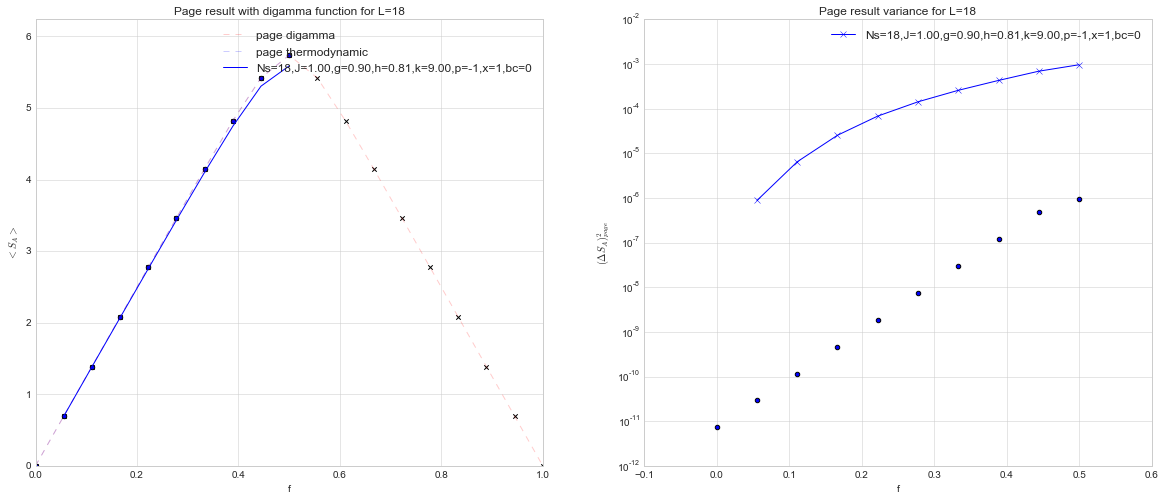

In [11]:
plot_model_av(model, fraction, directory)

### MANY

Ns=12,J=1.00,g=0.90,h=0.81,k=6.00,p=-1,x=1,bc=0
	->N=814
Ns=14,J=1.00,g=0.90,h=0.81,k=7.00,p=-1,x=1,bc=0
	->N=3269
Ns=16,J=1.00,g=0.90,h=0.81,k=8.00,p=-1,x=1,bc=0
	->N=13105
Ns=18,J=1.00,g=0.90,h=0.81,k=9.00,p=-1,x=1,bc=0
	->N=52419
Ns=20,J=1.00,g=0.90,h=0.81,k=10.00,p=-1,x=1,bc=0
	->N=209708


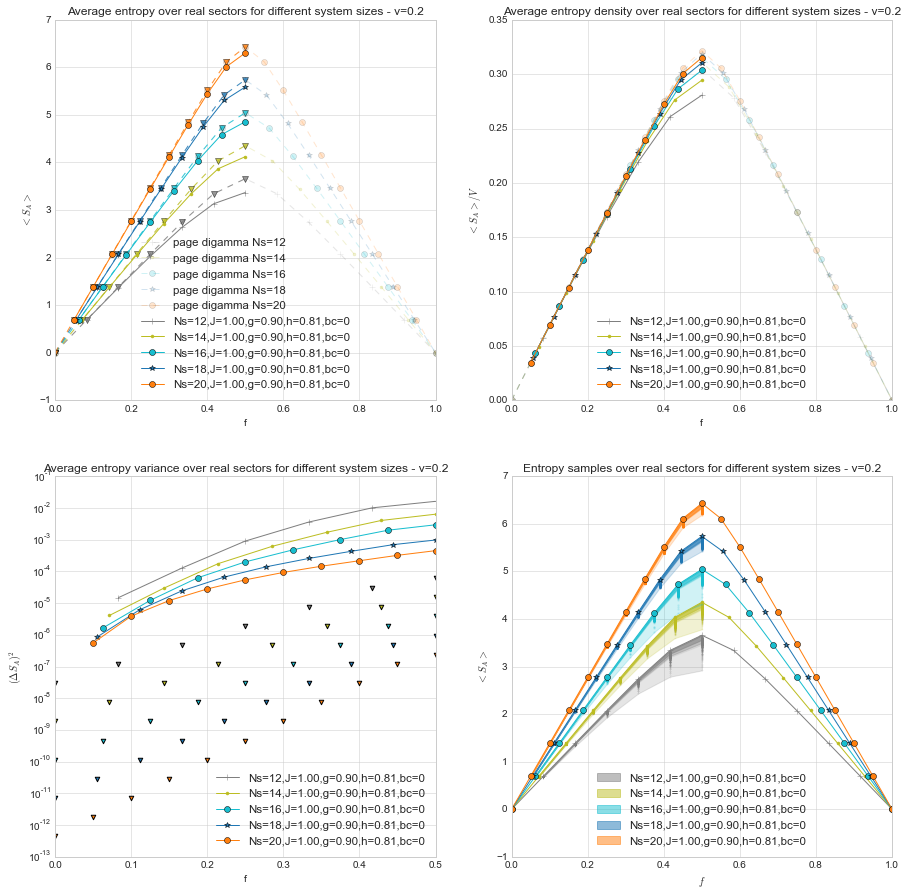

In [12]:
Ls=[16, 18, 20]
real = True
one_sec = False
plot_model_avs(Ls, model, fraction, directory, one_sec, real)


### CLOUD

Didnt capture all - for Ns = 16, bc = 0, N_val=10004
Did capture all - for Ns = 16, bc = 1, N_val=10000
Didnt capture all - for Ns = 18, bc = 0, N_val=9995
Too much for k=0,p=1,x=1,Ns=18 model
	->For 18 missing (0, 1),frac=10000,bc=1
Too much for k=0,p=-1,x=1,Ns=18 model
	->For 18 missing (0, -1),frac=10000,bc=1
Didnt capture all - for Ns = 18, bc = 1, N_val=2.0
Didnt capture all - for Ns = 20, bc = 0, N_val=10006
Too much for k=0,p=1,x=1,Ns=20 model
	->For 20 missing (0, 1),frac=10000,bc=1
Too much for k=0,p=-1,x=1,Ns=20 model
	->For 20 missing (0, -1),frac=10000,bc=1
Didnt capture all - for Ns = 20, bc = 1, N_val=2.0


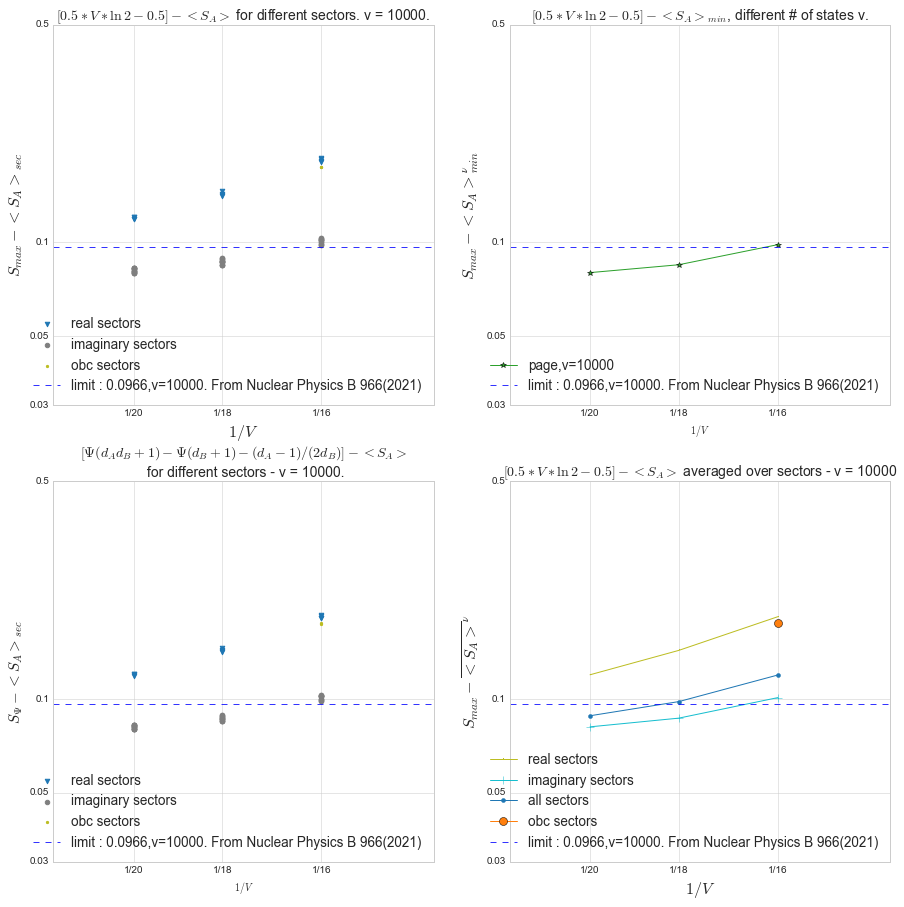

,16,18,20
10000,0.098397,0.084796,0.080005


In [36]:
Ls=[16, 18, 20]
fractions = [10000]

plot_difference_cloud(Ls, fractions, model, directory = directory)

## ED

### MODEL

In [154]:
Ns = 16
g = 0.90
h = 0.81

J = 1.0
w = 0.05
g0 = 0.0
J0 = 0.0

sym = False
k = 0.0
p = 1
x = 1

fraction=0.20

model = ising_transverse(Ns, J, J0, g, g0, h, w, sym, k, p, x)
directory = f"{kPSep}results{kPSep}resultsSym"

### SINGLE

C:\Users\maxgr\AppData\Local\Temp\ipykernel_1112\516729095.py:8: RuntimeWarning: overflow encountered in long_scalars
  return (d_a + d_b)/(d_a*d_b + 1.0) * polygamma(1, d_b + 1) - polygamma(1, d_a*d_b + 1) - ((d_a-1)*(d_a + 2 * d_b - 1))/(4*d_b * d_b * (d_a * d_b  + 1))
C:\Users\maxgr\AppData\Local\Temp\ipykernel_1112\516729095.py:8: RuntimeWarning: invalid value encountered in long_scalars
  return (d_a + d_b)/(d_a*d_b + 1.0) * polygamma(1, d_b + 1) - polygamma(1, d_a*d_b + 1) - ((d_a-1)*(d_a + 2 * d_b - 1))/(4*d_b * d_b * (d_a * d_b  + 1))
C:\Users\maxgr\AppData\Local\Temp\ipykernel_1112\516729095.py:8: RuntimeWarning: divide by zero encountered in long_scalars
  return (d_a + d_b)/(d_a*d_b + 1.0) * polygamma(1, d_b + 1) - polygamma(1, d_a*d_b + 1) - ((d_a-1)*(d_a + 2 * d_b - 1))/(4*d_b * d_b * (d_a * d_b  + 1))


(      L_a      av_S
 0  0.0625  0.689391
 1  0.1250  1.376370
 2  0.1875  2.054660
 3  0.2500  2.723300
 4  0.3125  3.374600
 5  0.3750  3.988220
 6  0.4375  4.505050
 7  0.5000  4.752720,
 '13107')

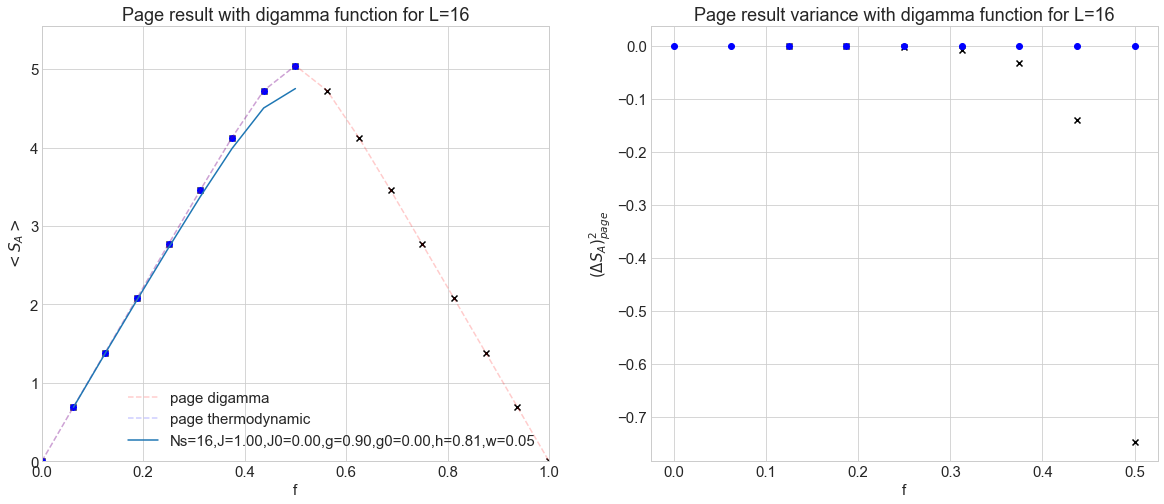

In [55]:
plot_model_av(model, fraction, directory)

### MULTIPLE

C:\Users\maxgr\AppData\Local\Temp\ipykernel_1112\516729095.py:8: RuntimeWarning: overflow encountered in long_scalars
  return (d_a + d_b)/(d_a*d_b + 1.0) * polygamma(1, d_b + 1) - polygamma(1, d_a*d_b + 1) - ((d_a-1)*(d_a + 2 * d_b - 1))/(4*d_b * d_b * (d_a * d_b  + 1))
C:\Users\maxgr\AppData\Local\Temp\ipykernel_1112\516729095.py:8: RuntimeWarning: invalid value encountered in long_scalars
  return (d_a + d_b)/(d_a*d_b + 1.0) * polygamma(1, d_b + 1) - polygamma(1, d_a*d_b + 1) - ((d_a-1)*(d_a + 2 * d_b - 1))/(4*d_b * d_b * (d_a * d_b  + 1))
C:\Users\maxgr\AppData\Local\Temp\ipykernel_1112\516729095.py:8: RuntimeWarning: divide by zero encountered in long_scalars
  return (d_a + d_b)/(d_a*d_b + 1.0) * polygamma(1, d_b + 1) - polygamma(1, d_a*d_b + 1) - ((d_a-1)*(d_a + 2 * d_b - 1))/(4*d_b * d_b * (d_a * d_b  + 1))


5    0.621293
Name: av_S, dtype: float64
6    0.42626
Name: av_S, dtype: float64
7    0.292457
Name: av_S, dtype: float64


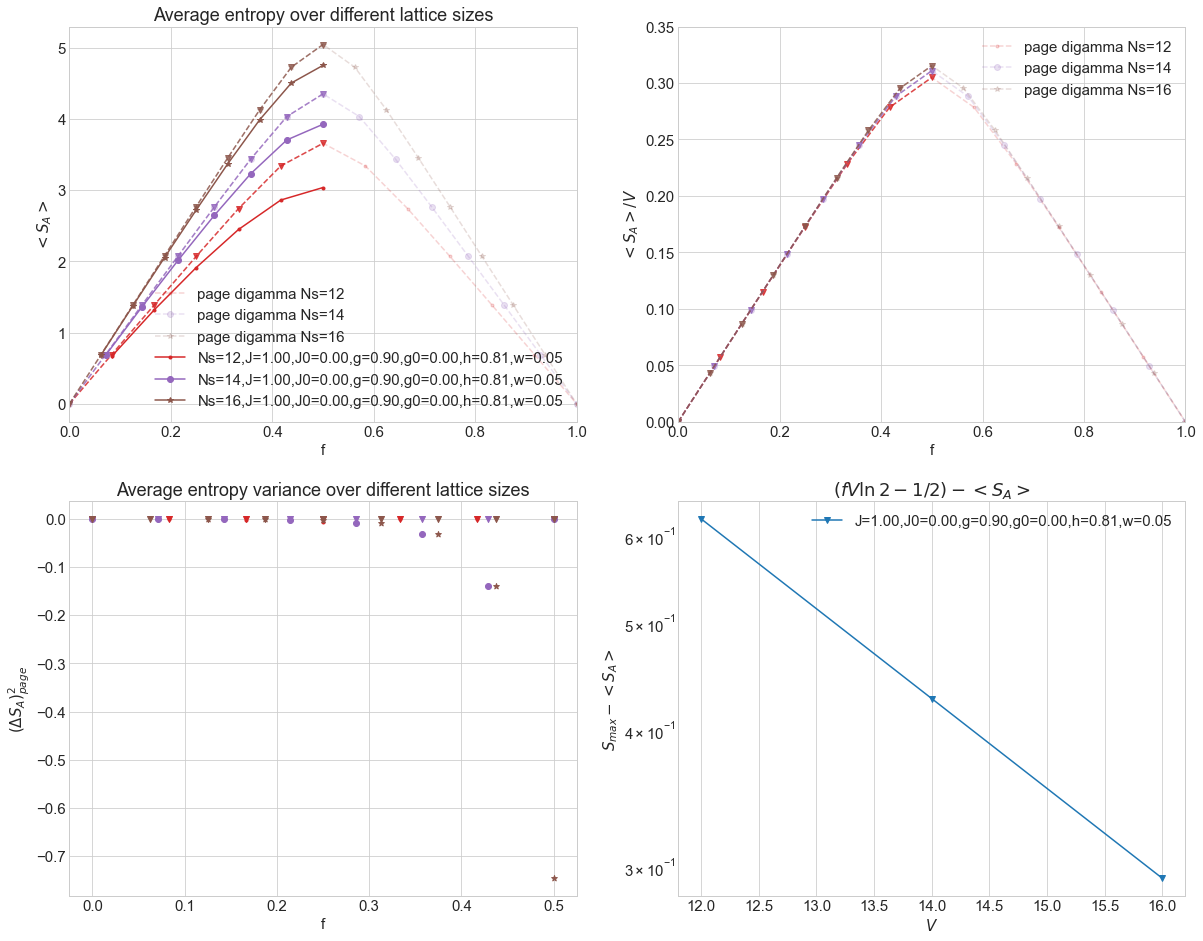

In [155]:
Ls=[12, 14, 16]
plot_model_avs(Ls, model, fraction, directory)